In [1]:
ls

dga_detect/  README.md  Untitled.ipynb


In [2]:
cd dga_detect/

/home/sun/git/Machine-learning-stuffs/dga_detect


In [3]:
import sklearn.feature_extraction
import pandas as pd
import matplotlib.pylab as plt

In [4]:
# 设置绘图大小
plt.rcParams['figure.figsize'] = (14.0, 5.0)
plt.rcParams['axes.grid'] = True

In [5]:
#读取合法域名
alexa_dataframe = pd.read_csv('data/alexa_100k.csv', names=['rank','url'], header=None, encoding='utf-8')
alexa_dataframe.head() #读取出来所有的域名数据

,rank,url
0,1,facebook.com
1,2,google.com
2,3,youtube.com
3,4,yahoo.com
4,5,baidu.com


In [6]:
#提取域名
import tldextract
import numpy as np

def domain_extract(url):
    ext = tldextract.extract(url)
    if (not ext.suffix):
        return np.nan
    else:
        return ext.domain

alexa_dataframe['domain'] = [ domain_extract(url) for url in alexa_dataframe['url']]
del alexa_dataframe['rank']
del alexa_dataframe['url']
alexa_dataframe.count()
alexa_dataframe.head()

No handlers could be found for logger "tldextract"


,domain
0,facebook
1,google
2,youtube
3,yahoo
4,baidu


In [7]:
alexa_dataframe.tail()

,domain
99995,rhbabyandchild
99996,rm
99997,sat1
99998,nahimunkar
99999,musi


In [8]:
alexa_dataframe.isnull().count()

domain    100000
dtype: int64

In [9]:
#发现有很多nan数据，丢弃
alexa_dataframe = alexa_dataframe.dropna()
#重复的域名数据对这次的训练没什么意义，所以抛弃
alexa_dataframe = alexa_dataframe.drop_duplicates()

In [10]:
alexa_dataframe.count()

domain    91377
dtype: int64

In [11]:
#设置分类
alexa_dataframe['class'] = 'legit'
#打乱数据
alexa_dataframe = alexa_dataframe.reindex(np.random.permutation(alexa_dataframe.index))
alexa_totol = alexa_dataframe.shape[0]
print "合法域名总数 %d" %alexa_totol

#据说掐头去尾后效果更好我们最后测试一下
hole_out_alexa = alexa_dataframe[int(alexa_totol*.9):]
alexa_dataframe = alexa_dataframe[:int(alexa_totol*.9)]
print "使用的合法域名总数 %d" %alexa_dataframe.shape[0]

合法域名总数 91377
使用的合法域名总数 82239


In [12]:
alexa_dataframe.head()

,domain,class
70083,wildretroporn,legit
47835,auctionsniper,legit
64427,penggilabookmark,legit
82951,alarabonline,legit
86299,kinoshita-koumuten,legit


In [13]:
######开始读取dga域名
dga_dataframe = pd.read_csv('data/dga_domains.txt',names=['raw_domain'],header=None,encoding='utf-8')
dga_dataframe.head()
#print dga_dataframe.count()

,raw_domain
0,04055051be412eea5a61b7da8438be3d.info
1,1cb8a5f36f.info
2,30acd347397c34fc273e996b22951002.org
3,336c986a284e2b3bc0f69f949cb437cb.info
4,336c986a284e2b3bc0f69f949cb437cb.org


In [14]:
test = [domain_extract(url) for url in dga_dataframe['raw_domain']]
test = pd.DataFrame(test)
print dga_dataframe.count()
test.count()
#很明显从测试的结果来看，直接用tldextract提取dga域名效果差极了，我们注意到域名可以似乎直接通过.分割

raw_domain    2669
dtype: int64


0    436
dtype: int64

In [15]:
#分割出域名
dga_dataframe['domain'] = dga_dataframe.applymap(lambda x: x.split('.')[0].lower())
#print dga_dataframe.head()
del dga_dataframe['raw_domain']
#删除为空和重复的数据
dga_dataframe = dga_dataframe.dropna()
dga_dataframe = dga_dataframe.drop_duplicates()
dga_totol = dga_dataframe.shape[0]
print "dga 域名总数为 %d" %dga_totol
#print dga_dataframe.head()

#设置分类
dga_dataframe['class'] = 'dga'
#听说掐头去尾效果更好。
hold_out_dga = dga_dataframe[int(dga_totol*0.9):]
dga_dataframe = dga_dataframe[:int(dga_totol*0.9)]
print "使用的域名总数为 %d" %dga_dataframe.shape[0]


dga 域名总数为 2664
使用的域名总数为 2397


In [16]:
dga_dataframe.head()

,domain,class
0,04055051be412eea5a61b7da8438be3d,dga
1,1cb8a5f36f,dga
2,30acd347397c34fc273e996b22951002,dga
3,336c986a284e2b3bc0f69f949cb437cb,dga
5,40a43e61e56a5c218cf6c22aca27f7ee,dga


In [17]:
#把所有域名链接到一起
all_domains = pd.concat([alexa_dataframe,dga_dataframe],ignore_index=True)
print all_domains.head()
all_domains.count()

               domain  class
0       wildretroporn  legit
1       auctionsniper  legit
2    penggilabookmark  legit
3        alarabonline  legit
4  kinoshita-koumuten  legit


domain    84636
class     84636
dtype: int64

In [18]:
#从之前可以看到合法域名和dga域名有着明显长度区别。
all_domains['length'] = [len(x) for x in all_domains['domain']]

In [19]:
import math
from collections import Counter
#熵的计算公式
def entropy(x):
    p,lns = Counter(x) ,float(len(x))
    return -sum(count/lns * math.log(count/lns,2) for count in p.values())
#同样，将域名的信息熵作为一个特征
all_domains['entropy'] = [entropy(x) for x in all_domains['domain']]
all_domains.head()

,domain,class,length,entropy
0,wildretroporn,legit,13,3.180833
1,auctionsniper,legit,13,3.392747
2,penggilabookmark,legit,16,3.500000
3,alarabonline,legit,12,2.855389
4,kinoshita-koumuten,legit,18,3.503258


In [20]:
all_domains.tail()

,domain,class,length,entropy
84631,ulxxqduryvv,dga,11,2.913977
84632,ummvzhin,dga,8,2.750000
84633,umsgnwgc,dga,8,2.750000
84634,umzsbhpkrgo,dga,11,3.459432
84635,umzuyjrfwyf,dga,11,2.913977


In [21]:
##################开始绘图

/home/sun/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


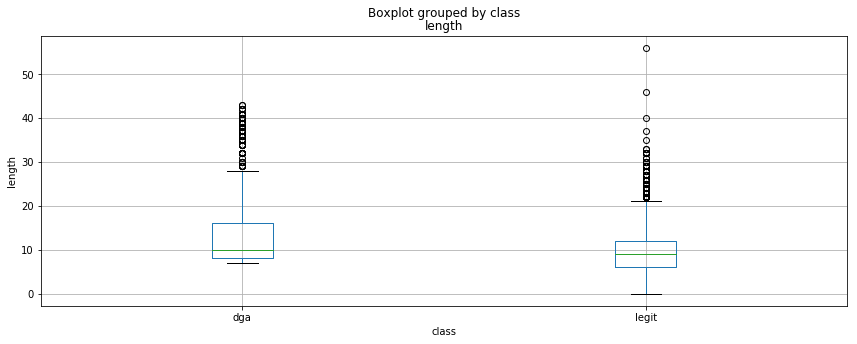

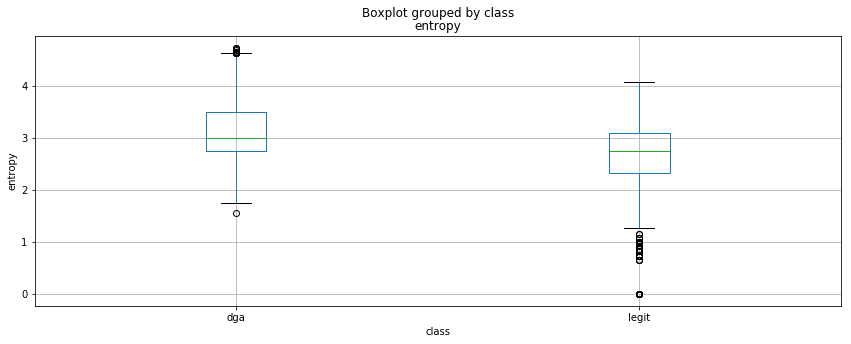

In [22]:
#通过盒图来查看整个数据分布
import matplotlib.pylab as plt
all_domains.boxplot('length','class')
plt.ylabel('length')
all_domains.boxplot('entropy','class')
plt.ylabel('entropy')
plt.show()

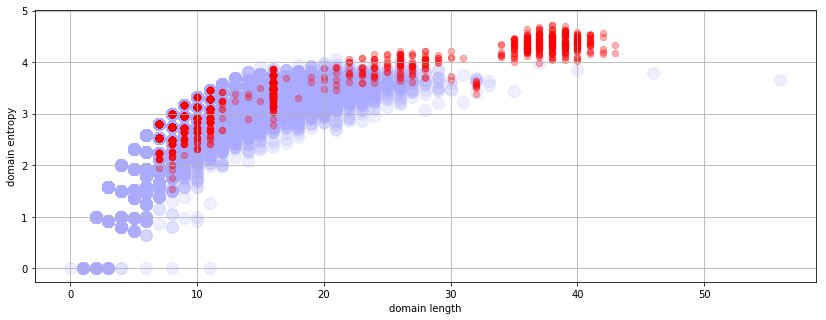

In [23]:
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
alexa = all_domains[~cond]
plt.scatter(alexa['length'],alexa['entropy'],s=140,c='#aaaaff',label='Alexa',alpha=.2)
plt.scatter(dga['length'],dga['entropy'],s=40,c='r',label='dga',alpha=.3)
plt.xlabel('domain length')
plt.ylabel('domain entropy')
plt.show()

In [24]:
#构建训练X输入矩阵
X = all_domains.as_matrix(['length','entropy'])
#构建y结果
y= np.array(all_domains['class'].tolist())

In [25]:
import sklearn.ensemble
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=20)

In [26]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(clf,X,y,cv=5,n_jobs=4)
print scores
#emmmmm这个大概97.5的准确率甚是喜人啊

/home/sun/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[ 0.9768431   0.97666588  0.97707804  0.97636911  0.9733546 ]


In [27]:
from sklearn.cross_validation import train_test_split
#取一个8比2的分割来通过混淆矩阵看一下预测效果
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [28]:
from sklearn.metrics import confusion_matrix
labels = ['legit','dga']
cm = confusion_matrix(y_test,y_pred,labels)
print "legit     dga"
print cm

legit     dga
[[16384    21]
 [  439    84]]


In [29]:
##但是我们看到几乎所有的域名都被分到合法区域，对dga的探测效果非常差
##试试增加更多的特征能不能提升效果
##利用文本分析来创建特征,首先提取通用向量
alexa_vc = sklearn.feature_extraction.text.CountVectorizer(analyzer = 'char')
alexa_vc

CountVectorizer(analyzer='char', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [30]:
################### NGrams算法
counts_matrix = alexa_vc.fit_transform(alexa_dataframe['domain'])
alexa_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = alexa_vc.get_feature_names()

In [31]:
#创建字典
word_dataframe = pd.read_csv('data/words.txt',names=['word'],header=None,dtype={'word':np.str},encoding='utf-8')
#################高能注意##############
#word_dataframe = word_dataframe[word_dataframe['word'].map(lambda x: str(x).isalpha())]
word_dataframe = word_dataframe.applymap(lambda x: str(x).lower())
word_dataframe.head()

,word
0,1080
1,10-point
2,10th
3,11-point
4,12-point


In [47]:
dict_vc = sklearn.feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=1e-5, max_df=1.0)
counts_matrix = dict_vc.fit_transform(word_dataframe['word'])
dict_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = dict_vc.get_feature_names()


In [33]:
def ngram_count(domain):
    alexa_match = alexa_counts * alexa_vc.transform([domain]).T
    dict_match = dict_counts * dict_vc.transform([domain]).T
    print '%s Alexa match %d Dict match: %d' %(domain,alexa_match,dict_match)
##测试一些例子
# Examples:
ngram_count('google')
ngram_count('facebook')
ngram_count('1cb8a5f36f')
ngram_count('pterodactylfarts')
ngram_count('ptes9dro-dwacty2lfa5rrts')
ngram_count('beyonce')
ngram_count('bey666on4ce')

google Alexa match 27 Dict match: 15
facebook Alexa match 36 Dict match: 28
1cb8a5f36f Alexa match 37 Dict match: 0
pterodactylfarts Alexa match 73 Dict match: 77
ptes9dro-dwacty2lfa5rrts Alexa match 104 Dict match: 37
beyonce Alexa match 32 Dict match: 16
bey666on4ce Alexa match 44 Dict match: 1


In [34]:
all_domains['alexa_grams'] = alexa_counts * alexa_vc.transform(all_domains['domain']).T
all_domains['word_grams'] = dict_counts * dict_vc.transform(all_domains['domain']).T    
all_domains.head()

,domain,class,length,entropy,alexa_grams,word_grams
0,wildretroporn,legit,13,3.180833,59.815121,64.717220
1,auctionsniper,legit,13,3.392747,60.492861,67.217935
2,penggilabookmark,legit,16,3.500000,72.582843,61.465622
3,alarabonline,legit,12,2.855389,56.268948,54.747862
4,kinoshita-koumuten,legit,18,3.503258,81.661109,57.471055


In [35]:
all_domains.tail()

,domain,class,length,entropy,alexa_grams,word_grams
84631,ulxxqduryvv,dga,11,2.913977,45.321817,6.570487
84632,ummvzhin,dga,8,2.750000,34.648715,7.322644
84633,umsgnwgc,dga,8,2.750000,35.159127,3.917716
84634,umzsbhpkrgo,dga,11,3.459432,47.996822,2.579784
84635,umzuyjrfwyf,dga,11,2.913977,45.797549,0.000000


In [36]:
#总会有存在两个ngram差值不存在的位置
all_domains['diff'] = all_domains['alexa_grams'] - all_domains['word_grams']
all_domains.sort_values(['diff'],ascending=True).head(10)

,domain,class,length,entropy,alexa_grams,word_grams,diff
21878,article-directory-free-submission-free-content,legit,46,3.786816,209.230149,296.502115,-87.271966
38582,universal-pictures-international-germany,legit,40,3.843943,182.951227,260.874717,-77.923490
30713,internetmarketingmastermindalliance,legit,35,3.451310,163.064807,238.869357,-75.804550
18961,stirringtroubleinternationally,legit,30,3.481728,139.375894,213.229322,-73.853428
81480,americansforresponsiblesolutions,legit,32,3.667838,148.798858,222.154479,-73.355621
70055,commercialistatelematico,legit,24,3.229574,111.940200,174.536563,-62.596362
59042,internationallatestnews,legit,23,3.153572,107.885584,167.854105,-59.968521
4643,courrierinternational,legit,21,3.177566,98.602357,157.410113,-58.807755
58884,consumerincentivepromotions,legit,27,3.439711,125.055162,183.839349,-58.784187
49163,electrical-engineering-portal,legit,29,3.456974,133.481872,191.406109,-57.924237


In [37]:
all_domains.sort_values(['diff'], ascending=False).head(30)
#很好，差值得划分出了dga

,domain,class,length,entropy,alexa_grams,word_grams,diff
83640,lrl28i65l68j56f22a17o51p22l48cwjro21dug13eu,dga,43,4.175696,163.605861,1.612784,161.993077
82971,fyo21o21h54a37o41gtfsf22d40g43oqnvhuc59i25,dga,42,4.252453,161.021455,2.071882,158.949573
83544,kuh24p52d40n30n20lwp32mxo31g43lvlsgtdwh54,dga,41,4.198777,158.605675,0.954243,157.651433
83099,h54k47gvd50p32dvm29iwi35eyf22d60mwb38j36h64,dga,43,4.332787,159.388414,3.295787,156.092627
82611,d20eqh34b38mxj16fxcrm59crg63i65gva37p22n20,dga,42,4.564820,158.065761,2.643453,155.422308
82757,e61mupwpyp62gtp62ksd60bse31i15c29e61b18at,dga,41,4.217819,160.848948,5.686422,155.162526
83300,itm19frp62b28auo21esjzo31f42o11j66lqdsc69,dga,41,4.373051,158.637189,3.625724,155.011465
82599,cyh14fqh14h54e41bukveqa37j66aql18i35g53i15,dga,42,4.204834,157.029594,2.688420,154.341174
82359,aypvj36a27d30ezb48k17ixgqaxf12e31c39k17pu,dga,41,4.491460,155.700720,1.414973,154.285747
83966,o61pxn40bwfwcqi25k37k37cxn40mqeqi15m49h14,dga,41,4.393899,154.018117,0.000000,154.018117


In [38]:
###############绘图时间


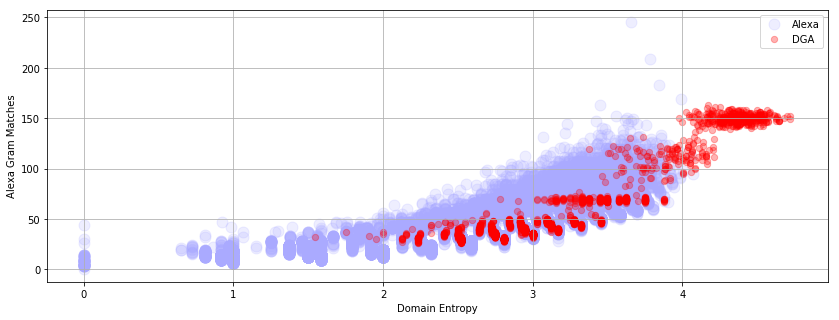

In [39]:
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
legit = all_domains[~cond]
plt.scatter(legit['entropy'], legit['alexa_grams'],  s=120, c='#aaaaff', label='Alexa', alpha=.2)
plt.scatter(dga['entropy'], dga['alexa_grams'], s=40, c='r', label='DGA', alpha=.3)
plt.legend()
plt.xlabel('Domain Entropy')
plt.ylabel('Alexa Gram Matches')
plt.show()

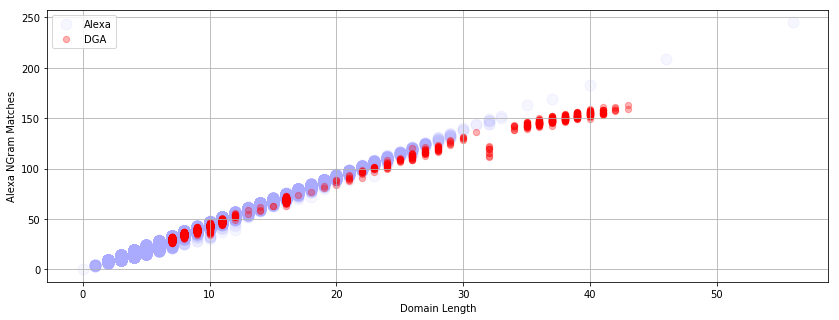

In [40]:
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
legit = all_domains[~cond]
plt.scatter(legit['length'], legit['alexa_grams'], s=120, c='#aaaaff', label='Alexa', alpha=.1)
plt.scatter(dga['length'], dga['alexa_grams'], s=40, c='r', label='DGA', alpha=.3)
plt.legend()
plt.xlabel('Domain Length')
plt.ylabel('Alexa NGram Matches')
plt.show()

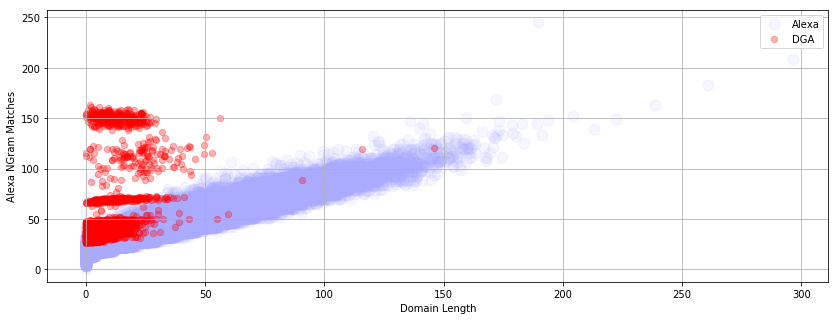

In [41]:
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
legit = all_domains[~cond]
plt.scatter(legit['word_grams'], legit['alexa_grams'], s=120, c='#aaaaff', label='Alexa', alpha=.1)
plt.scatter(dga['word_grams'], dga['alexa_grams'], s=40, c='r', label='DGA', alpha=.3)
plt.legend()
plt.xlabel('Domain Length')
plt.ylabel('Alexa NGram Matches')
plt.show()

In [42]:
all_domains[(all_domains['word_grams']==0)].head()
###在word_gram ==0及完全匹配到dict的域名

,domain,class,length,entropy,alexa_grams,word_grams,diff
13,jjwxc,legit,5,1.921928,19.509249,0.0,19.509249
20,gfy,legit,3,1.584963,12.521962,0.0,12.521962
102,vsnl,legit,4,2.000000,17.901695,0.0,17.901695
125,mt,legit,2,1.000000,9.082470,0.0,9.082470
131,90he,legit,4,2.000000,15.417200,0.0,15.417200


In [43]:
#用我们现在的四个特征。不对，五个特征试试cm值是否可观
X = all_domains.as_matrix(['length','entropy','alexa_grams','word_grams'])
y = np.array(all_domains['class'].tolist())
#new_legit = legit.sample(8000)
#new_domains = pd.concat([new_legit,dga],ignore_index=True)
#X = all_domains.as_matrix(['length','entropy','alexa_grams','word_grams'])
#y = all_domains(new_domains['class'].tolist())
#此处记录一个悲伤的故事，由于自己的蠢，把y = np.array(all_domains['class'].tolist())
#写成了y = np.array(all_domains['domain'].tolist())
#造成了一系列内存错误，损坏了一个系统，debug用了10多个小时的时间，加上重新配置环境重装系统怕是有二十几个小时
#梦里都有他的影子
#以此纪念，2017.10.20

In [44]:
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
#from sklearn import tree
#clf1 = tree.DecisionTreeRegressor()

clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [45]:
y_pred = clf.predict(X_test)

In [46]:
from sklearn.metrics import confusion_matrix
labels = ['legit','dga']
cm = confusion_matrix(y_test,y_pred,labels)
cm
#这个混淆矩阵就让人满意多了

array([[16407,    63],
       [   96,   362]])

In [48]:
#再看下正确律
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(clf,X,y,cv=5,n_jobs=4)
print scores
#一开始用长度和熵得出的 [ 0.9768431   0.97666588  0.97707804  0.97636911  0.9733546 ]
#相比较而言提高了很多十分接近99.
#比较满意

[ 0.98983932  0.98989839  0.9906658   0.98907072  0.98924731]


In [130]:
#再写个测试函数
def test_it(domain):
    
    _alexa_match = alexa_counts * alexa_vc.transform([domain]).T # 原理同上
    _dict_match = dict_counts * dict_vc.transform([domain]).T
    #_X = [len(domain), entropy(domain), _alexa_match[0], _dict_match[0]]
    #print len(domain), entropy(domain), _alexa_match[0], _dict_match[0]
    arr = np.array([len(domain), entropy(domain), _alexa_match[0], _dict_match[0]])
    print '%s : %s' % (domain, clf.predict(arr.reshape(1,-1))[0])
    #print type(arr)
    #print arr
    #print type(X[0])
    #print X[0]
    #print clf.predict(X[0].reshape(1,-1))
    #print '%s : %s' % (domain, clf.predict(arr))

In [134]:
test_it('google')
test_it('google')
test_it('google88')
test_it('facebook')
test_it('1cb8a5f36f')
test_it('pterodactylfarts')
test_it('ptes9dro-dwacty2lfa5rrts')
test_it('beyonce')
test_it('bey666on4ce')
test_it('supersexy')
test_it('yourmomissohotinthesummertime')
test_it('35-sdf-09jq43r')
test_it('sunxueliang')
test_it('sunxueliang96')

google : legit
google : legit
google88 : legit
facebook : legit
1cb8a5f36f : dga
pterodactylfarts : legit
ptes9dro-dwacty2lfa5rrts : dga
beyonce : legit
bey666on4ce : dga
supersexy : legit
yourmomissohotinthesummertime : legit
35-sdf-09jq43r : dga
sunxueliang : legit
sunxueliang96 : legit


In [ ]:
#附一篇文章回头再看S. Yadav, A. K. K. Reddy, A. L. N. Reddy, and S. Ranjan, “Detecting algorithmically generated malicious domain names,” presented at the the 10th annual conference, New York, New York, USA, 2010, pp. 48–61. [http://conferences.sigcomm.org/imc/2010/papers/p48.pdf

In [136]:
#存个模型回头写程序用
from sklearn.externals import joblib
import os
os.chdir("model_save")
joblib.dump(clf,'train_model_1.0.m')

['train_model_1.0.m']